This notebook plots the STORM-B tracks on a map.

# Plot STORM tracks and Ecoregions

In [14]:
from pathlib import Path
from climada.hazard import TCTracks

DATA = Path('/Data/STORM/STORM_tracks_v4')
BASINS = ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']
imax = 1
FIGS = Path('/Results/')

print('its starting!')
all_tracks = TCTracks()
for basin in BASINS:
    fname = f"STORM_DATA_IBTRACS_{basin}_1000_YEARS_{0}.txt"
    tracks_basin = TCTracks.from_simulations_storm(DATA / fname)
    print(f'Basin {basin} ensemble 0 done')
    for i in range(1, imax):
        fname = f"STORM_DATA_IBTRACS_{basin}_1000_YEARS_{i}.txt"
        tracks_basin.append(TCTracks.from_simulations_storm(DATA / fname).data)
        print(f'Basin {basin} ensemble {i} done')
    all_tracks.append(tracks_basin.data)

its starting!
Basin EP ensemble 0 done
Basin NA ensemble 0 done
Basin NI ensemble 0 done
Basin SI ensemble 0 done
Basin SP ensemble 0 done
Basin WP ensemble 0 done


In [15]:
import copy
some_tracks = copy.deepcopy(all_tracks)

In [16]:
# No need to plot all tracks. Choose a random sample
import numpy as np
N = 10
sel = np.arange(1, all_tracks.size, int(all_tracks.size / N))

In [17]:
some_tracks.data = [all_tracks.data[i] for i in sel]

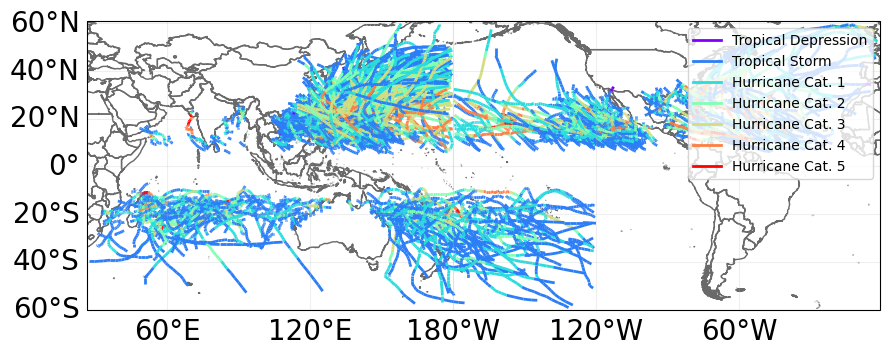

In [10]:
# Quick check
axis = some_tracks.plot()

In [50]:
# No need to plot all tracks. Choose a random sample
import numpy as np
N = 10000
sel = np.arange(1, all_tracks.size, int(all_tracks.size / N))

In [51]:
import copy
some_more_tracks = copy.deepcopy(all_tracks)
some_more_tracks.data = [all_tracks.data[i] for i in sel]

In [20]:
import geopandas as gpd
from pathlib import Path
ECO_DATA = Path('/Data/Ecoregions2017/')
eco_reg_geom = gpd.GeoDataFrame.from_file(ECO_DATA).set_crs(4326)

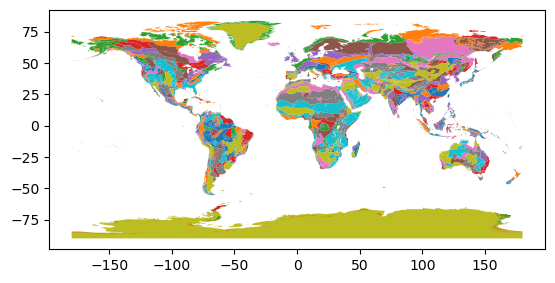

In [21]:
eco_reg_geom.plot('COLOR');

In [22]:
# Convert 0-360 to -180+180
def rotate_center_180(vals):
    return ((vals - 180) % 360) - 180

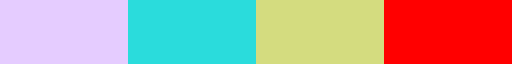

In [52]:
import matplotlib as mpl
import numpy as np
SAFFIR_SIM_CAT = [64, 96, 112, 1000]
"""Saffir-Simpson Hurricane Wind Scale in kn based on NOAA (1-2 ; 3 ; 4-5)"""

CAT_NAMES = {
    0: 'Below SSHWS 1: < 33m/s',
    1: 'Low: 33 − 49m/s SSHWS 1-2',
    2: 'Middle: 49 − 58m/s - SSHWS 3',
    3: 'High: ≥ 58 m/s - SSHWS 4-5',
}
"""Saffir-Simpson category names."""


CAT_COLORS = mpl.cm.rainbow(np.linspace(0, 1, len(SAFFIR_SIM_CAT)))
#CAT_COLORS[0] = np.array([1,1,1,1])
CMAP = mpl.colors.ListedColormap(colors=CAT_COLORS)
CMAP.colors[0][-1] = 0.2 # Set transparency for no storm 
NORM = mpl.colors.BoundaryNorm([0] + SAFFIR_SIM_CAT, len(SAFFIR_SIM_CAT))

CMAP

In [48]:
from climada.util import plot as u_plot
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import shapely as sh
import pandas as pd

def plot_ecoreg_tracks_lmh(tracks, ecoreg_geom, ccrs, figsize, center_lon = -20, legend=True, filename=None, kwargs={}):

    axis = ecoreg_geom.plot(figsize=(30, 10), color=ecoreg_geom.COLOR, alpha=0.5)
    axis.set_ylim([-7.5e6, 7e6])
    axis.set_xlim([-1.63e7, 1.64e7])
    
    #for color, geometry in zip(ecoreg_geom.COLOR, ecoreg_geom.geometry):
    #    axis.add_geometries([geometry], crs=ccrs, facecolor=color, edgecolor='dimgray', alpha=0.2)

    geom_list = []
    for track in tracks.data:
        lonlat = np.stack([rotate_center_180(track.lon.values), track.lat.values], axis=-1)
        segments = np.stack([lonlat[:-1], lonlat[1:]], axis=1)
        mask = (segments[:, 0, 0] > 100) & (segments[:, 1, 0] < -100)
        segments[mask, 1, 0] = 180
        mask = (segments[:, 0, 0] < -100) & (segments[:, 1, 0] > 100)
        segments[mask, 1, 0] = -180
        mask = (segments[:, 0, 0] > center_lon) & (segments[:, 1, 0] <= center_lon)
        segments[mask, 1, 0] = center_lon + 0.001
        mask = (segments[:, 0, 0] < center_lon) & (segments[:, 1, 0] >= center_lon)
        segments[mask, 1, 0] = center_lon - 0.001
        lines= [sh.LineString(seg) for seg in segments]
        wind_values = track.max_sustained_wind.values[:-1]
        geom_list.append(gpd.GeoDataFrame({'wind':wind_values}, geometry=lines, crs='4326').to_crs(PROJ_PACIFIC))
    geom = pd.concat(geom_list)
    geom.plot(ax=axis, column='wind', cmap=CMAP, norm=NORM, linestyle='solid')
        
    if legend:
        leg_lines = [Line2D([0], [0], color=CAT_COLORS[i_col], lw=2)
                     for i_col in range(len(SAFFIR_SIM_CAT))]
        leg_names = [CAT_NAMES[i_col] for i_col in sorted(CAT_NAMES.keys())]
        legend_tc = axis.legend(leg_lines[0:], leg_names[0:], prop={'size':15}, loc='lower right')
        
        biomes_handles = [mpatches.Patch(color=color) for color in ecoreg_geom.COLOR_BIO.unique()]
        biomes_labels = ecoreg_geom.BIOME_NAME.unique()
        plt.legend(biomes_handles, biomes_labels, ncol=3, prop={'size':15}, numpoints=1, loc='lower left')  
        axis.add_artist(legend_tc)
        
    axis.axis('off')
    plt.tight_layout()
    if filename:
        fig = axis.get_figure()
        fig.savefig(filename, bbox_inches='tight')
    return axis, geom

### Centered on Pacific map

In [25]:
import cartopy.crs as ccrs
PROJ = f'+proj=eck4 +lon_0=0'
#PROJ_PACIFIC = '+proj=eck4 +lon_0=-2e7'
PROJ_PACIFIC = ccrs.Projection('+proj=eck4 +lon_0=-2e7')

LAT_BOUNDS = (-60, 60)
LAT_BOUNDS_PROJ = (-7e6, 7e6)

In [27]:
eco_reg_geom_pacific_plot = eco_reg_geom.set_crs(4326).to_crs(PROJ_PACIFIC)

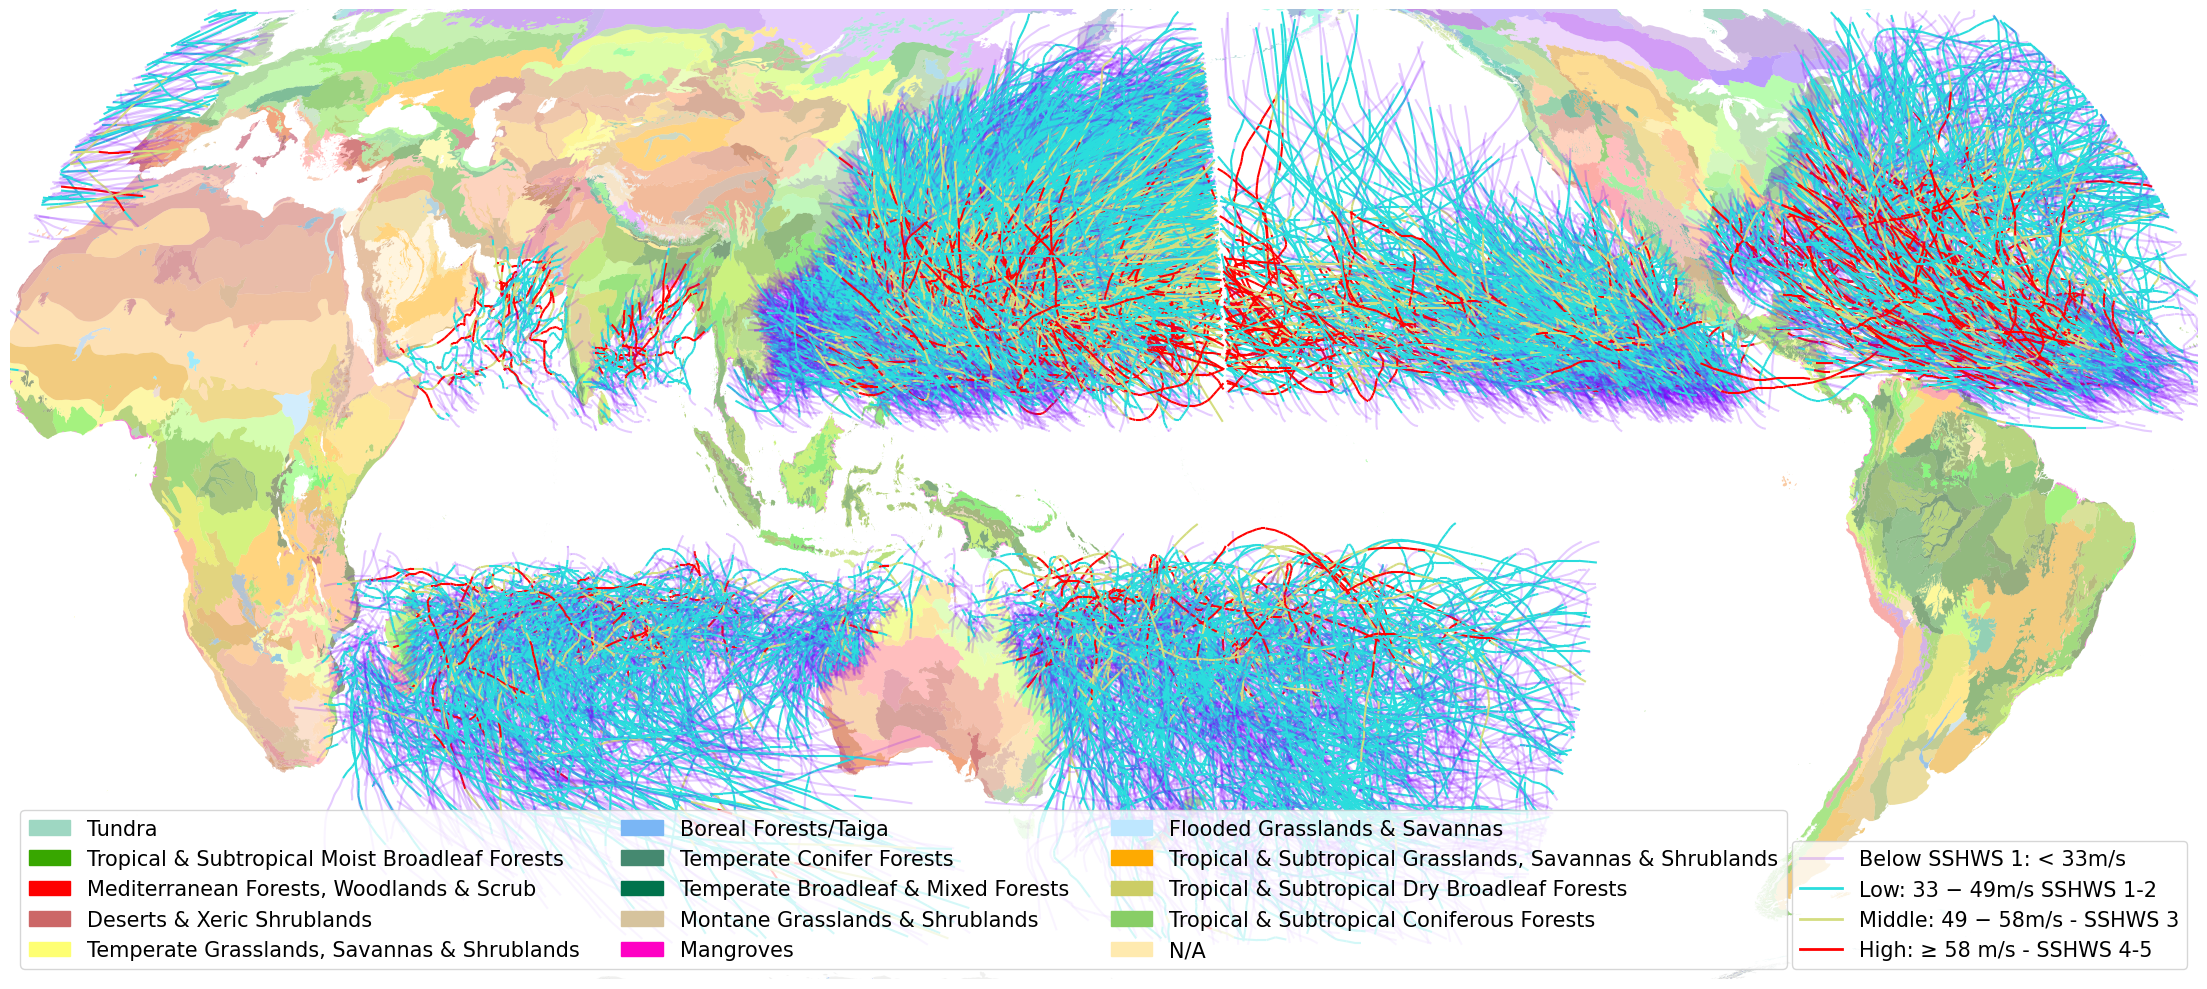

In [53]:
ax, geom = plot_ecoreg_tracks_lmh(some_more_tracks, eco_reg_geom_pacific_plot, PROJ_PACIFIC, (30, 10), filename=FIGS / 'tracks_ecoreg_pacific_v2.pdf') 